In [1]:
import pandas as pd

dataset_path = "datasets/global.csv"

df = pd.read_csv(dataset_path)
df = df.sort_values(by=["student_id", "period", "discipline"])

print(f"Quantidade de registros: {len(df)}\n")
print(df.head())

Quantidade de registros: 35995

       id  student_id                      birthdate sex                city  \
2138    1       99951  1992-05-21 02:00:00.000 -0300   F  Faxinal do Soturno   
5665    3       99951  1992-05-21 02:00:00.000 -0300   F  Faxinal do Soturno   
9160    2       99951  1992-05-21 02:00:00.000 -0300   F  Faxinal do Soturno   
28710   4       99955  1989-01-06 04:00:00.000 -0200   M  Faxinal do Soturno   
28312   8       99955  1989-01-06 04:00:00.000 -0200   M  Faxinal do Soturno   

                   course  period week_day  \
2138   Ciências Contábeis  2021/1   Quarta   
5665   Ciências Contábeis  2021/2  Segunda   
9160   Ciências Contábeis  2022/1    Terça   
28710  Ciências Contábeis  2025/1  Segunda   
28312  Ciências Contábeis  2025/1   Quarta   

                                 discipline    status   g1   g2  final_grade  \
2138               Matemática Aplicada - 60  Aprovado  7.5  7.0          7.2   
5665       Contabilidade Intermediária - 60  Aprov

In [2]:
# Remoção de colunas não utilizadas
df = df.drop(columns=["birthdate", "sex", "city", "week_day", "period", "g1", "g2", "class_skips"])

# Filtragem de registros apenas de alunos de Sistemas de Informação
df = df[df["course"] == "Sistemas de Informação"]

# Tratamento da coluna "status"
df['status'] = df['status'].astype(str).str.lower().eq('aprovado').astype('int8')

# Normalização da coluna "final_grade"
df['final_grade'] = pd.to_numeric(df['final_grade'], errors='coerce')  # valores inválidos viram NaN
df['final_grade'] = (df['final_grade'] / 10).round(2)
df.loc[df['final_grade'] == -0.1, 'final_grade'] = 0

# Remoção do "traço" e do crédito da coluna disciplina no nome da mesma
df["discipline"] = df["discipline"].str.split(" - ").str[0].str.strip()
df["discipline"] = df["discipline"].str.split(" -72").str[0].str.strip() # Remoção para caso especial em "Gestão da Qualidade de Software"

# Remoção da coluna do curso
df = df.drop(columns=["course"])

# Salva dataset atual filtrado apenas para Sistemas de Informação
df.to_csv("datasets/sistemas_de_informacao.csv", index=False, encoding="utf-8")

print(f"Quantidade de registros: {len(df)}\n")
print(df.head())

Quantidade de registros: 4604

       id  student_id                                 discipline  status  \
133   248      100004            Gestão da Qualidade de Software       1   
111   249      100004                Laboratório de Algoritmo II       0   
134   247      100004  Organização e Arquitetura de Computadores       1   
653   246      100004                        Psicologia do Líder       1   
1918  250      100004       Programação para Dispositivos Móveis       1   

      final_grade  
133          0.88  
111          0.00  
134          0.82  
653          0.77  
1918         1.00  


In [3]:
# Mostra a quantidade de disciplinas (com agrupamento)
discipline_counts = df["discipline"].value_counts()

print(f"Quantidade de disciplinas: {len(discipline_counts)}\n")
print("Disciplina X Quantidade\n")
print(discipline_counts)

Quantidade de disciplinas: 110

Disciplina X Quantidade

discipline
Estrutura de Dados                                                                                 201
Organização e Arquitetura de Computadores                                                          193
Competência Competitiva no Universo da Tecnologia                                                  178
Probabilidade e Estatística                                                                        165
Laboratório de Algoritmos II                                                                       151
                                                                                                  ... 
Trabalho de Conclusão de Curso em Administração                                                      1
Cultura Humanista e Igualdade nas Relações Étnico-Raciais e História Afro-Brasileira e Indígena      1
O Mundo do Trabalho e a Administração                                                                1
Perso

In [4]:
# Salva dataset atual apenas registros de disciplinas agrupadas para fins de análise
discipline_counts_df = discipline_counts.reset_index()
discipline_counts_df.columns = ["discipline", "count"]
discipline_counts_df.to_csv("datasets/sistemas_de_informacao_disciplines_grouped.csv", index=False, encoding="utf-8")
print(df.head())

       id  student_id                                 discipline  status  \
133   248      100004            Gestão da Qualidade de Software       1   
111   249      100004                Laboratório de Algoritmo II       0   
134   247      100004  Organização e Arquitetura de Computadores       1   
653   246      100004                        Psicologia do Líder       1   
1918  250      100004       Programação para Dispositivos Móveis       1   

      final_grade  
133          0.88  
111          0.00  
134          0.82  
653          0.77  
1918         1.00  


In [5]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, title="Matriz de Confusão"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=["Reprovado (0)", "Aprovado (1)"],
                yticklabels=["Reprovado (0)", "Aprovado (1)"])
    plt.xlabel("Previsto")
    plt.ylabel("Real")
    plt.title(title)
    plt.show()

In [6]:
df_random_forest = df.copy(deep=True)

In [ ]:
semester4_disciplines = [
    "Banco de Dados Aplicado",
    "Engenharia de Software",
    "Liderança nas Profissões Tecnológicas",
    "Língua Inglesa IV",
    "Programação Orientada a Objetos",
    "Redes de Computadores",
]

# Criar colunas de target (aprovado em cada disciplina do 4º semestre)
for disc in semester4_disciplines:
    df_random_forest[disc + '_target'] = (
        (df_random_forest['discipline'] == disc) & (df_random_forest['status'] == 1)
    ).astype(int)

# Features: pivot das notas
features_df = df_random_forest.pivot_table(
    index='student_id',
    columns='discipline',
    values='final_grade',
    aggfunc='mean'
).fillna(0)

# Targets: um target por disciplina do 4º semestre
targets_df = df_random_forest.groupby('student_id')[
    [d+'_target' for d in semester4_disciplines]
].max()


=== RandomForest para Banco de Dados Aplicado ===
Acurácia: 0.8983050847457628
              precision    recall  f1-score   support

           0       0.92      0.96      0.94        48
           1       0.78      0.64      0.70        11

    accuracy                           0.90        59
   macro avg       0.85      0.80      0.82        59
weighted avg       0.89      0.90      0.89        59

Matriz de Confusão:
 [[46  2]
 [ 4  7]]


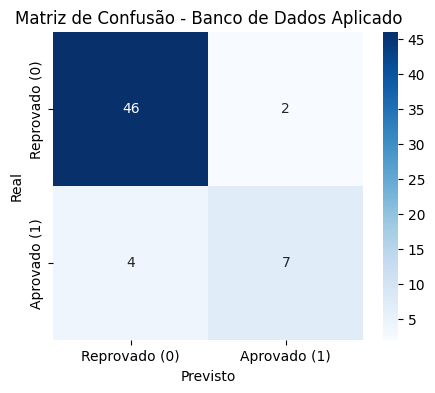


=== RandomForest para Engenharia de Software ===
Acurácia: 0.864406779661017
              precision    recall  f1-score   support

           0       0.87      0.98      0.92        49
           1       0.75      0.30      0.43        10

    accuracy                           0.86        59
   macro avg       0.81      0.64      0.68        59
weighted avg       0.85      0.86      0.84        59

Matriz de Confusão:
 [[48  1]
 [ 7  3]]


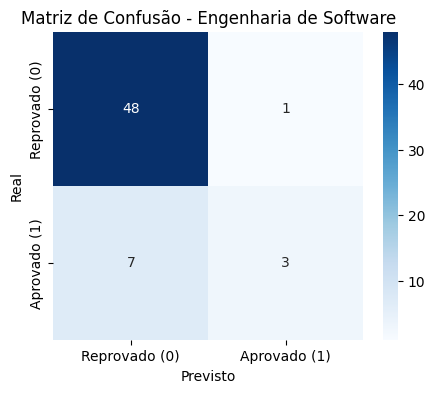


=== RandomForest para Liderança nas Profissões Tecnológicas ===
Acurácia: 0.8813559322033898
              precision    recall  f1-score   support

           0       0.87      1.00      0.93        47
           1       1.00      0.42      0.59        12

    accuracy                           0.88        59
   macro avg       0.94      0.71      0.76        59
weighted avg       0.90      0.88      0.86        59

Matriz de Confusão:
 [[47  0]
 [ 7  5]]


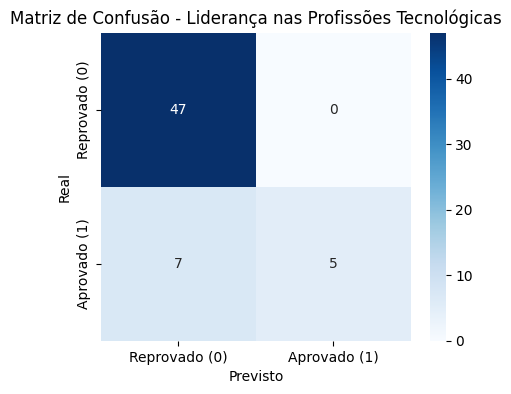


=== RandomForest para Língua Inglesa IV ===
Acurácia: 0.9661016949152542
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        52
           1       1.00      0.71      0.83         7

    accuracy                           0.97        59
   macro avg       0.98      0.86      0.91        59
weighted avg       0.97      0.97      0.96        59

Matriz de Confusão:
 [[52  0]
 [ 2  5]]


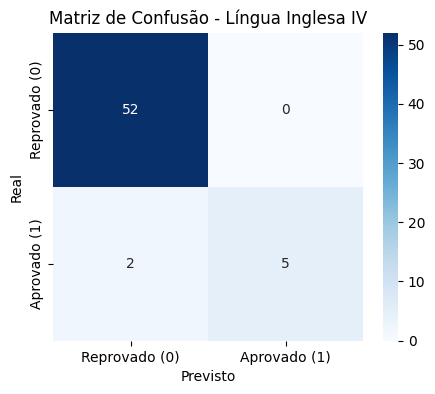


=== RandomForest para Programação Orientada a Objetos ===
Acurácia: 0.9322033898305084
              precision    recall  f1-score   support

           0       0.94      0.98      0.96        47
           1       0.90      0.75      0.82        12

    accuracy                           0.93        59
   macro avg       0.92      0.86      0.89        59
weighted avg       0.93      0.93      0.93        59

Matriz de Confusão:
 [[46  1]
 [ 3  9]]


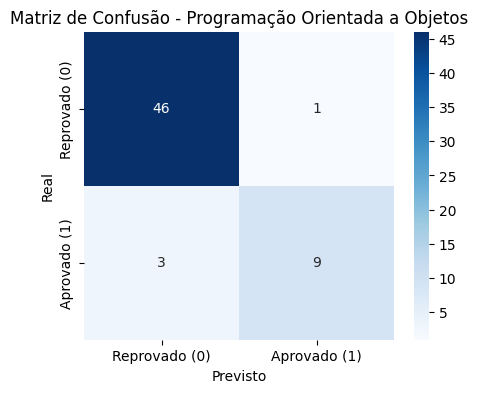


=== RandomForest para Redes de Computadores ===
Acurácia: 0.864406779661017
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        41
           1       0.78      0.78      0.78        18

    accuracy                           0.86        59
   macro avg       0.84      0.84      0.84        59
weighted avg       0.86      0.86      0.86        59

Matriz de Confusão:
 [[37  4]
 [ 4 14]]


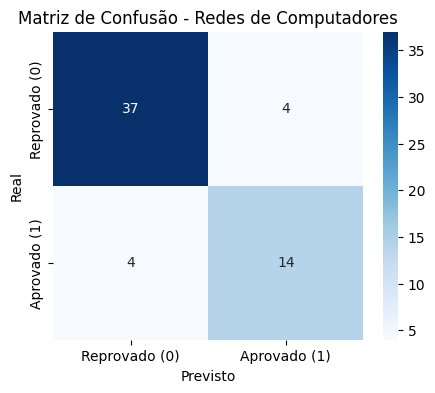

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

for disc in semester4_disciplines:
    target_col = disc + "_target"

    if target_col not in targets_df.columns:
        print(f"Disciplina {disc} não possui target definido, pulando...")
        continue

    # Target (só alunos que já cursaram ou têm status definido)
    y = targets_df[target_col].dropna()
    # Features: removemos a própria disciplina (para evitar vazamento)
    X = features_df.loc[y.index].drop(columns=[disc], errors="ignore")

    if y.nunique() < 2:  # precisa ter pelo menos 2 classes
        print(f"Disciplina {disc} não possui variação suficiente no target, pulando...")
        continue

    # Split treino/teste
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Modelo RandomForest
    model = RandomForestClassifier(
        n_estimators=1000,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        bootstrap=True,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n=== RandomForest para {disc} ===")
    print("Acurácia:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred))
    plot_confusion_matrix(y_test, y_pred, title=f"Matriz de Confusão - {disc}")

In [9]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

for disc in semester4_disciplines:
    target_col = disc + "_target"

    if target_col not in targets_df.columns:
        print(f"Disciplina {disc} não possui target definido, pulando...")
        continue

    # Target (só alunos que já cursaram ou têm status definido)
    y = targets_df[target_col].dropna()
    # Features: removemos a própria disciplina (para evitar vazamento de informação)
    X = features_df.loc[y.index].drop(columns=[disc], errors="ignore")

    if y.nunique() < 2:  # precisa ter pelo menos 2 classes
        print(f"Disciplina {disc} não possui variação suficiente no target, pulando...")
        continue

    # Split treino/teste
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Modelo Gradient Boosting
    model = GradientBoostingClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=4,
        min_samples_split=5,
        min_samples_leaf=3,
        random_state=42
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n=== GradientBoosting para {disc} ===")
    print("Acurácia:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred))


=== GradientBoosting para Banco de Dados Aplicado ===
Acurácia: 0.8813559322033898
              precision    recall  f1-score   support

           0       0.92      0.94      0.93        48
           1       0.70      0.64      0.67        11

    accuracy                           0.88        59
   macro avg       0.81      0.79      0.80        59
weighted avg       0.88      0.88      0.88        59

Matriz de Confusão:
 [[45  3]
 [ 4  7]]

=== GradientBoosting para Engenharia de Software ===
Acurácia: 0.864406779661017
              precision    recall  f1-score   support

           0       0.87      0.98      0.92        49
           1       0.75      0.30      0.43        10

    accuracy                           0.86        59
   macro avg       0.81      0.64      0.68        59
weighted avg       0.85      0.86      0.84        59

Matriz de Confusão:
 [[48  1]
 [ 7  3]]

=== GradientBoosting para Liderança nas Profissões Tecnológicas ===
Acurácia: 0.8983050847457628
  

In [10]:
# Minhas notas para previsão posterior
my_grades = {
    'Cálculo Numérico': 9.3,
    'Fundamentos de Sistemas de Informação': 8.2,
    'Laboratório de Algoritmos I': 9.5,
    'Língua Inglesa I': 9,
    'O Mundo do Trabalho e a Tecnologia': 9.2,
    'Pensamento Computacional': 9.1,
    'Competência Competitiva no Universo da Tecnologia': 10,
    'Estrutura de Dados': 8.3,
    'Língua Inglesa II': 9.0,
    'Organização e Arquitetura de Computadores': 9.3,
    'Probabilidade e Estatística': 8.5,
    'Gerenciamento de Serviços de TI': 8.8,
    'Classificação e Pesquisa de Dados': 7.0,
    'Fundamentos de Banco de Dados': 9.1,
    'Língua Inglesa III': 9.0,
    'Matemática Discreta': 7.4,
    'Personalidade e Carreiras Tecnológicas': 9.0,
    'Sistemas Operacionais': 10
}